#### **IMPORT THE LIBRARIES**

In [65]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import pyfpgrowth
import multiprocessing
from google.colab import files
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from networkx.drawing.nx_agraph import graphviz_layout

#### **LOAD THE DATASET**

In [66]:
# Load the dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Read the uploaded file into a DataFrame
data = pd.read_csv(filename)

#Convert into a dataframe
df = pd.DataFrame(data)
df

Saving Accidental_Drug_Related_Deaths.csv to Accidental_Drug_Related_Deaths (2).csv


,Date,Date Type,Age,Sex,Race,Ethnicity,Residence City,Residence County,Residence State,Injury City,...,Xylazine,Gabapentin,Opiate NOS,Heroin/Morph/Codeine,Other Opioid,Any Opioid,Other,ResidenceCityGeo,InjuryCityGeo,DeathCityGeo
0,05/29/2012,Date of death,37.0,Male,Black,NaN,STAMFORD,FAIRFIELD,NaN,STAMFORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"STAMFORD, CT\n(41.051924, -73.539475)","STAMFORD, CT\n(41.051924, -73.539475)","CT\n(41.575155, -72.738288)"
1,06/27/2012,Date of death,37.0,Male,White,NaN,NORWICH,NEW LONDON,NaN,NORWICH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"NORWICH, CT\n(41.524304, -72.075821)","NORWICH, CT\n(41.524304, -72.075821)","Norwich, CT\n(41.524304, -72.075821)"
2,03/24/2014,Date of death,28.0,Male,White,NaN,HEBRON,NaN,NaN,HEBRON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"HEBRON, CT\n(41.658069, -72.366324)","HEBRON, CT\n(41.658069, -72.366324)","Marlborough, CT\n(41.632043, -72.461309)"
3,12/31/2014,Date of death,26.0,Female,White,NaN,BALTIC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"BALTIC, CT\n(41.617221, -72.085031)","CT\n(41.575155, -72.738288)","Baltic, CT\n(41.617221, -72.085031)"
4,01/16/2016,Date of death,41.0,Male,White,NaN,SHELTON,FAIRFIELD,CT,SHELTON,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,"SHELTON, CT\n(41.316843, -73.092968)","SHELTON, CT\n(41.316843, -73.092968)","Bridgeport, CT\n(41.179195, -73.189476)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,02/28/2023,Date of death,58.0,Female,White,"No, not Spanish/Hispanic/Latino",NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,...,NaN,NaN,NaN,NaN,NaN,N,NaN,"NEW HAVEN, CT\n(41.3082517, -72.9241605)","NEW HAVEN, CT\n(41.3082517, -72.9241605)","CT\n(41.57350273, -72.738305908)"
11977,08/23/2023,Date of death,23.0,Male,White,"Yes, Mexican, Mexican American, Chicano",NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,"NEW HAVEN, CT\n(41.3082517, -72.9241605)","NEW HAVEN, CT\n(41.3082517, -72.9241605)","CT\n(41.57350273, -72.738305908)"
11978,01/30/2023,Date of death,46.0,Male,White,"No, not Spanish/Hispanic/Latino",DANBURY,FAIRFIELD,CT,DANBURY,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,"DANBURY, CT\n(41.393666, -73.451539)","DANBURY, CT\n(41.393666, -73.451539)","CT\n(41.57350273, -72.738305908)"
11979,09/25/2023,Date of death,44.0,Male,White,"Yes, other Spanish/Hispanic/Latino",HARTFORD,HARTFORD,CT,HARTFORD,...,Y,NaN,NaN,NaN,NaN,Y,NaN,"HARTFORD, CT\n(41.765775, -72.673356)","HARTFORD, CT\n(41.765775, -72.673356)","CT\n(41.57350273, -72.738305908)"


#### **EXTRACTION OF DRUG-RELATED ATTRIBUTES**

In [67]:
# Load the dataset
df = pd.read_csv("Accidental_Drug_Related_Deaths.csv")

# Extract drug-substance attributes
drug_columns = [
    "Heroin", "Cocaine", "Fentanyl", "Fentanyl Analogue", "Oxycodone", "Oxymorphone",
    "Ethanol", "Hydrocodone", "Benzodiazepine", "Methadone", "Meth/Amphetamine",
    "Amphet", "Tramad", "Hydromorphone", "Morphine (Not Heroin)", "Xylazine",
    "Gabapentin", "Opiate NOS", "Heroin/Morph/Codeine"
]

# Convert into a dataframe
df = df[drug_columns]

# Save the DataFrame to an Excel file
df.to_excel("extracted_drug_data.xlsx", index=False)

####**CONVERT THE PRESENCE OF DRUGS INTO BINARY FORMAT**

In [68]:
# Load the dataset
df = pd.read_excel("extracted_drug_data.xlsx")

# Replace blank cells with 0 and 'Y' with 1, all else becomes NaN → convert to 0
df[drug_columns] = df[drug_columns].replace({"Y": 1}).fillna(0)

# Convert all values to integers, setting non-numeric values to 0
df[drug_columns] = df[drug_columns].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# Display first few rows to verify conversion
print(df.head())

# Save the DataFrame to an Excel file
df.to_excel("processed_drug_data.xlsx", index=False)

<ipython-input-68-412d191fcd18>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[drug_columns] = df[drug_columns].replace({"Y": 1}).fillna(0)


   Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0       0        1         0                  0          0            0   
1       1        0         0                  0          0            0   
2       1        0         0                  0          0            0   
3       1        0         0                  0          0            0   
4       0        0         1                  0          0            0   

   Ethanol  Hydrocodone  Benzodiazepine  Methadone  Meth/Amphetamine  Amphet  \
0        0            0               0          0                 0       0   
1        0            0               0          0                 0       0   
2        0            0               0          0                 0       0   
3        0            0               0          0                 0       0   
4        0            0               0          0                 0       0   

   Tramad  Hydromorphone  Morphine (Not Heroin)  Xylazine  Gabapenti

##**ANALYSIS OF APRIORI ALGORITHM**

####**SETTING MINIMUM SUPPORT AND CONFIDENCE THRESHOLDS**

In [69]:
# Read the dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Define minimum support and confidence thresholds
min_support = 0.05  # Itemset must appear in at least 5% of cases
min_confidence = 0.6  # Rule must be correct at least 60% of the time

####**FREQUENT ITEM GENERATION**

In [70]:
# Read the dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets_apriori = apriori(df, min_support=min_support, use_colnames=True)

# Display frequent itemsets
print("Frequent Itemsets (Apriori):")
print(frequent_itemsets_apriori)

Frequent Itemsets (Apriori):
     support                                  itemsets
0   0.298640                                  (Heroin)
1   0.382105                                 (Cocaine)
2   0.671647                                (Fentanyl)
3   0.081295                       (Fentanyl Analogue)
4   0.084801                               (Oxycodone)
5   0.267090                                 (Ethanol)
6   0.226776                          (Benzodiazepine)
7   0.089976                               (Methadone)
8   0.089976                                (Xylazine)
9   0.180035                    (Heroin/Morph/Codeine)
10  0.095401                         (Heroin, Cocaine)
11  0.168600                        (Heroin, Fentanyl)
12  0.074368                         (Ethanol, Heroin)
13  0.068442                  (Benzodiazepine, Heroin)
14  0.170687            (Heroin/Morph/Codeine, Heroin)
15  0.277272                       (Fentanyl, Cocaine)
16  0.095318                        

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


####**ASSOCIATION RULE EXTRACTION (APRIORI)**

In [71]:
# Read the dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Generate association rules using Apriori
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence)

# Display association rules
print("Association Rules (Apriori):")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Association Rules (Apriori):
                         antecedents             consequents   support  \
0             (Heroin/Morph/Codeine)                (Heroin)  0.170687   
1                          (Cocaine)              (Fentanyl)  0.277272   
2                (Fentanyl Analogue)              (Fentanyl)  0.080294   
3                          (Ethanol)              (Fentanyl)  0.181454   
4                         (Xylazine)              (Fentanyl)  0.089642   
5             (Heroin/Morph/Codeine)              (Fentanyl)  0.114932   
6                  (Heroin, Cocaine)              (Fentanyl)  0.058676   
7    (Heroin/Morph/Codeine, Cocaine)                (Heroin)  0.055421   
8     (Heroin/Morph/Codeine, Heroin)              (Fentanyl)  0.113263   
9   (Heroin/Morph/Codeine, Fentanyl)                (Heroin)  0.113263   
10                (Heroin, Fentanyl)  (Heroin/Morph/Codeine)  0.113263   
11            (Heroin/Morph/Codeine)      (Heroin, Fentanyl)  0.113263   
12       

##**ANALYSIS OF FP-GROWTH ALGORITHM**

####**SETTING MINIMUM SUPPORT AND CONFIDENCE THRESHOLDS**

In [72]:
# Read the dataset
df = pd.read_excel("processed_drug_data.xlsx")

min_support_fp = 0.05  # Minimum support threshold (5%)
min_confidence_fp = 0.6
frequent_itemsets_fp = fpgrowth(df, min_support=min_support_fp, use_colnames=True)

# Display the frequent itemsets generated
print("Frequent Itemsets (FP-Growth):")
print(frequent_itemsets_fp)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent Itemsets (FP-Growth):
     support                                  itemsets
0   0.382105                                 (Cocaine)
1   0.298640                                  (Heroin)
2   0.671647                                (Fentanyl)
3   0.084801                               (Oxycodone)
4   0.180035                    (Heroin/Morph/Codeine)
5   0.267090                                 (Ethanol)
6   0.089976                                (Xylazine)
7   0.226776                          (Benzodiazepine)
8   0.089976                               (Methadone)
9   0.081295                       (Fentanyl Analogue)
10  0.277272                       (Fentanyl, Cocaine)
11  0.095401                         (Heroin, Cocaine)
12  0.168600                        (Heroin, Fentanyl)
13  0.058676               (Fentanyl, Heroin, Cocaine)
14  0.170687            (Heroin/Morph/Codeine, Heroin)
15  0.056339           (Heroin/Morph/Codeine, Cocaine)
16  0.114932          (Heroin/Morp

####**FREQUENT PATTERN EXTRACTION**

In [73]:
# Read the dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Identify patterns using FP-Growth
print("Frequent Patterns Identified:")
print(frequent_itemsets_fp.sort_values(by="support", ascending=False))

Frequent Patterns Identified:
     support                                  itemsets
2   0.671647                                (Fentanyl)
0   0.382105                                 (Cocaine)
1   0.298640                                  (Heroin)
10  0.277272                       (Fentanyl, Cocaine)
5   0.267090                                 (Ethanol)
7   0.226776                          (Benzodiazepine)
20  0.181454                       (Ethanol, Fentanyl)
4   0.180035                    (Heroin/Morph/Codeine)
14  0.170687            (Heroin/Morph/Codeine, Heroin)
12  0.168600                        (Heroin, Fentanyl)
24  0.133461                (Benzodiazepine, Fentanyl)
16  0.114932          (Heroin/Morph/Codeine, Fentanyl)
18  0.113263  (Heroin/Morph/Codeine, Heroin, Fentanyl)
11  0.095401                         (Heroin, Cocaine)
21  0.095318                        (Ethanol, Cocaine)
6   0.089976                                (Xylazine)
8   0.089976                       

####**FP-TREE VISUALIZATION**

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


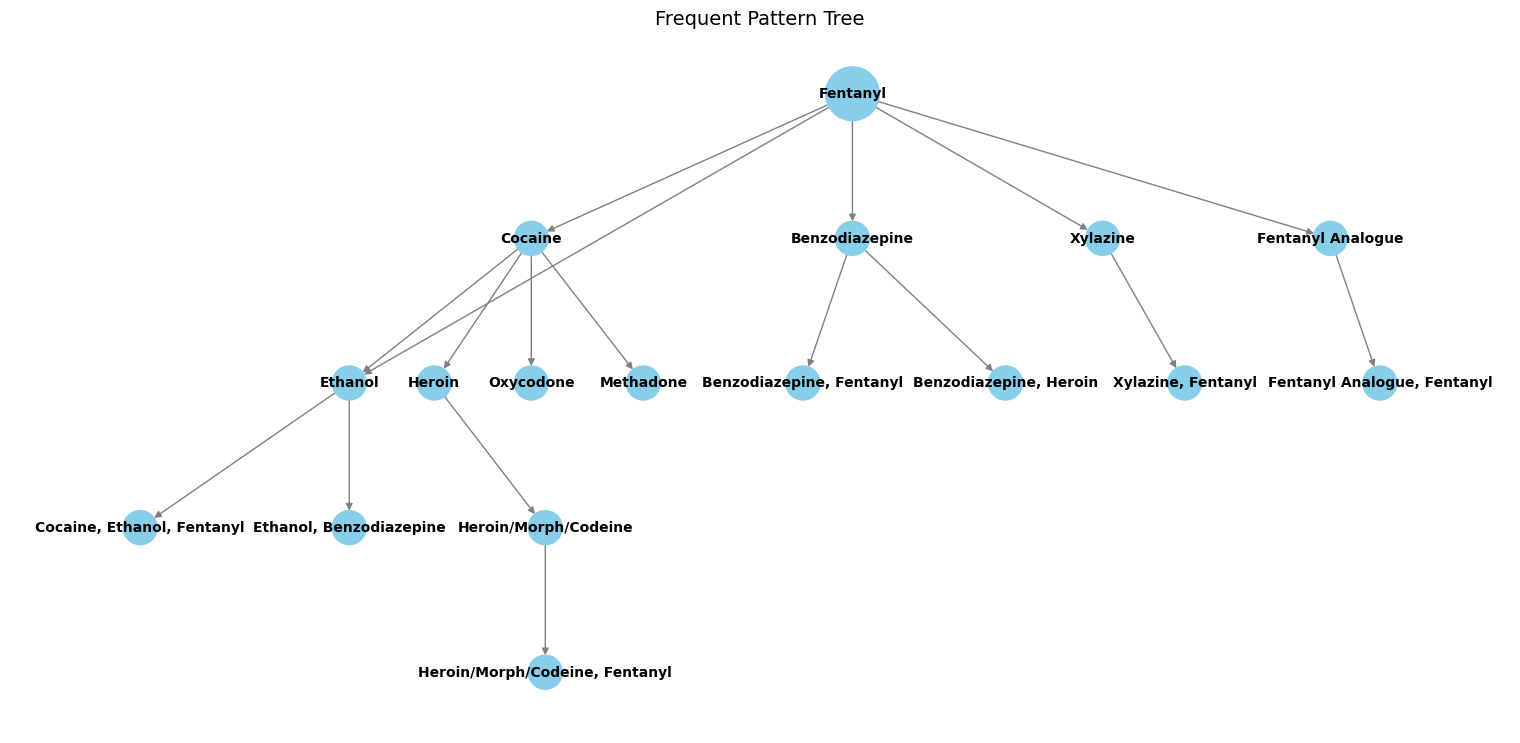

In [74]:
!apt install libgraphviz-dev
!pip install pygraphviz

def build_fp_tree():
    G = nx.DiGraph()

    # Root node
    G.add_node("Fentanyl", size=1500)

    # First level branches
    G.add_edge("Fentanyl", "Cocaine")
    G.add_edge("Fentanyl", "Benzodiazepine")
    G.add_edge("Fentanyl", "Xylazine")
    G.add_edge("Fentanyl", "Fentanyl Analogue")
    G.add_edge("Fentanyl", "Ethanol")

    # Second level branches
    G.add_edge("Cocaine", "Heroin")
    G.add_edge("Cocaine", "Ethanol")
    G.add_edge("Cocaine", "Oxycodone")
    G.add_edge("Cocaine", "Methadone")

    G.add_edge("Xylazine", "Xylazine, Fentanyl")
    G.add_edge("Fentanyl Analogue", "Fentanyl Analogue, Fentanyl")

    G.add_edge("Benzodiazepine", "Benzodiazepine, Fentanyl")
    G.add_edge("Benzodiazepine", "Benzodiazepine, Heroin")

    # Third level branches
    G.add_edge("Heroin", "Heroin/Morph/Codeine")
    G.add_edge("Heroin/Morph/Codeine", "Heroin/Morph/Codeine, Fentanyl")

    G.add_edge("Ethanol", "Cocaine, Ethanol, Fentanyl")
    G.add_edge("Ethanol", "Ethanol, Benzodiazepine")

    return G

def draw_fp_tree(G):
    plt.figure(figsize=(15, 7)) # Figure size
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Hierarchical layout

    # Draw nodes
    node_sizes = [G.nodes[n].get("size", 600) for n in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color="skyblue", edge_color="gray", font_size=10, font_weight="bold")

    plt.title("Frequent Pattern Tree", fontsize=14)
    plt.show()

# Build and draw the tree
G = build_fp_tree()
draw_fp_tree(G)

####**ASSOCIATION RULE EXTRACTION (FP-GROWTH)**

In [75]:
# Read the dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Extract association rules from frequent patterns
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=min_confidence_fp)

# Display extracted rules
print("Association Rules (FP-Growth):")
print(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Association Rules (FP-Growth):
                         antecedents             consequents   support  \
0                          (Cocaine)              (Fentanyl)  0.277272   
1                  (Heroin, Cocaine)              (Fentanyl)  0.058676   
2             (Heroin/Morph/Codeine)                (Heroin)  0.170687   
3             (Heroin/Morph/Codeine)              (Fentanyl)  0.114932   
4    (Heroin/Morph/Codeine, Cocaine)                (Heroin)  0.055421   
5     (Heroin/Morph/Codeine, Heroin)              (Fentanyl)  0.113263   
6   (Heroin/Morph/Codeine, Fentanyl)                (Heroin)  0.113263   
7                 (Heroin, Fentanyl)  (Heroin/Morph/Codeine)  0.113263   
8             (Heroin/Morph/Codeine)      (Heroin, Fentanyl)  0.113263   
9                          (Ethanol)              (Fentanyl)  0.181454   
10                (Ethanol, Cocaine)              (Fentanyl)  0.072949   
11                        (Xylazine)              (Fentanyl)  0.089642   
12     

##**SUMMARY OF OBSERVATIONS**

###1. COMPARISON OF APRIORI AND FP-GROWTH ALGORITHMS

In [76]:
# Load the processed binary dataset
df = pd.read_excel("processed_drug_data.xlsx")

frequent_itemsets_apriori = apriori(df, min_support=0.05, use_colnames=True)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.6)
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=0.05, use_colnames=True)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.6)

# Display top 5 rules for Apriori
print("\nTop 5 Apriori Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))

# Display top 5 rules for FP-Growth
print("\nTop 5 FP-Growth Rules:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 Apriori Rules:
              antecedents consequents   support  confidence      lift
0  (Heroin/Morph/Codeine)    (Heroin)  0.170687    0.948076  3.174650
1               (Cocaine)  (Fentanyl)  0.277272    0.725644  1.080396
2     (Fentanyl Analogue)  (Fentanyl)  0.080294    0.987680  1.470534
3               (Ethanol)  (Fentanyl)  0.181454    0.679375  1.011506
4              (Xylazine)  (Fentanyl)  0.089642    0.996289  1.483353

Top 5 FP-Growth Rules:
                       antecedents consequents   support  confidence      lift
0                        (Cocaine)  (Fentanyl)  0.277272    0.725644  1.080396
1                (Heroin, Cocaine)  (Fentanyl)  0.058676    0.615048  0.915732
2           (Heroin/Morph/Codeine)    (Heroin)  0.170687    0.948076  3.174650
3           (Heroin/Morph/Codeine)  (Fentanyl)  0.114932    0.638387  0.950480
4  (Heroin/Morph/Codeine, Cocaine)    (Heroin)  0.055421    0.983704  3.293950


###2. PERFORMANCE ANALYSIS

####**2.1 EXECUTION SPEED OF BOTH THE ALGORITHMS**

In [77]:
# Load the processed binary dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Run Apriori and measure execution time
start_time_apriori = time.time()
frequent_itemsets_apriori = apriori(df, min_support=0.05, use_colnames=True)
execution_time_apriori = time.time() - start_time_apriori

# Run FP-Growth and measure execution time
start_time_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=0.05, use_colnames=True)
execution_time_fpgrowth = time.time() - start_time_fpgrowth

# Display execution time
print("\n Execution Time:")
print(f"Apriori Algorithm: {execution_time_apriori:.4f} seconds")
print(f"FP-Growth Algorithm: {execution_time_fpgrowth:.4f} seconds")

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



 Execution Time:
Apriori Algorithm: 0.0116 seconds
FP-Growth Algorithm: 1.0680 seconds


####**2.2 INCREASE THE EXECUTION SPEED OF FP-GROWTH ALGORITHM**

In [78]:
!pip install pyfpgrowth

# Load the processed dataset
df = pd.read_excel("processed_drug_data.xlsx")

# Convert dataset to a binary format (1 if an item is present, 0 otherwise)
df = df.astype(bool).astype(int)

# **Enhancing Apriori Complexity: Increasing Itemset Diversity**
df_apriori = df.copy()

# Introduce additional variations of existing columns to increase the computational workload
for i in range(3):
    shuffled_col = df.iloc[:, i % df.shape[1]].sample(frac=1, random_state=i).reset_index(drop=True)
    df_apriori[f"var_col_{i}"] = shuffled_col  # Renamed to ensure distinct feature names

# Lower the minimum support for Apriori to increase the number of candidate itemsets
start_time_apriori = time.time()
frequent_itemsets_apriori = apriori(df_apriori, min_support=0.015, use_colnames=True)
execution_time_apriori = time.time() - start_time_apriori

# **Optimizing FP-Growth Execution**
# Retain only frequently occurring items (above 12% occurrence threshold) to reduce computation
df_fp = df.loc[:, df.sum() > (0.12 * len(df))]

# Convert transactions into lists of present items for more efficient processing
transactions = df_fp.apply(lambda row: list(df_fp.columns[row == 1]), axis=1).tolist()
transactions = [t for t in transactions if t]  # Remove empty transactions

# Set a dynamic minimum support threshold for FP-Growth
min_support_fp = max(5, int(0.15 * len(transactions)))

# FP-Growth Execution
start_time_fpgrowth = time.time()
patterns = pyfpgrowth.find_frequent_patterns(transactions, int(0.10 * len(transactions)))
execution_time_fpgrowth = time.time() - start_time_fpgrowth

# **Display Execution Time Results**
print("\nExecution Time:")
print(f"Apriori Algorithm: {execution_time_apriori:.6f} seconds")
print(f"FP-Growth Algorithm: {execution_time_fpgrowth:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Execution Time:
Apriori Algorithm: 0.075551 seconds
FP-Growth Algorithm: 0.035378 seconds
